In [289]:
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from sklearn import metrics

## 定义超参数

In [290]:
train_batch_size = 100    #每批处理的训练集数据
test_batch_size = 100     #每批处理的测试集数据
learning_rate = 0.01     #学习率
num_epoches = 50          #训练数据集的轮次
gamma = 0.9               #学习率衰减因子

In [291]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [292]:
train_x.shape, train_y.shape

((784, 5000), (10, 5000))

In [293]:
test_x.shape, test_y.shape

((784, 5000), (10, 5000))

In [294]:
train_x[:,0].shape,train_y[:,0].shape

((784,), (10,))

## 可视化输入图像 

label: 5


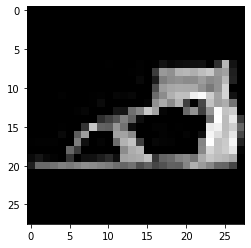

In [295]:
index = np.random.randint(train_x.shape[1])
img = train_x[:,index].reshape(28,28,1,order='C')
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
print('label:',np.argmax(train_y[:,index],axis=0))

## 构建原始数据集

In [296]:
transform = transforms.Compose([
    transforms.ToTensor(),                       # 归一化
    transforms.Normalize((0.5), (0.5)),        # 标准化
])
transform_data_aug =  transforms.Compose([       # 数据增广
    transforms.RandomHorizontalFlip(),           # 随机水平翻转
    transforms.RandomVerticalFlip(),             # 随机上下翻转
    transforms.RandomRotation(15),               # 随机旋转-15°~15°
    transforms.Resize([32,32]),
    transforms.RandomCrop([28, 28]),             # 随机裁剪
    transforms.ToTensor(),                       # 归一化
    transforms.Normalize((0.5), (0.5)),        # 标准化
])

In [297]:
train_dataset = []  # 训练集
test_dataset = []   # 测试集
for i in range(train_x.shape[1]):
    img = train_x[:,i].reshape(28,28,order='C')
    train_dataset.append([transform(img),np.argmax(train_y[:,i],axis=0)])
    img = Image.fromarray(img)
    train_dataset.append([transform_data_aug(img),np.argmax(train_y[:,i],axis=0)])
for i in range(test_x.shape[1]):
    img = test_x[:,i].reshape(28,28,order='C')
    test_dataset.append([transform(img),np.argmax(test_y[:,i],axis=0)])

In [298]:
#训练集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
#测试集
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [299]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [300]:
def out(w,k,s,p):
    return (w-k+2*p)/s+1
out(11,3,2,1)

6.0

# 定义网络结构

In [301]:
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net,self).__init__()
        self.features = nn.Sequential(  #打包
            nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1),      # input[1, 28, 28]  output[48, 28, 28] 
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),      
            nn.MaxPool2d(kernel_size=2),                               # output[48, 14, 14] 
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=0),     # output[96, 12, 12]
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                               # output[96, 6, 6]
            nn.Conv2d(96, 168, kernel_size=3, stride=1, padding=1),    # output[168, 6, 6]
            nn.BatchNorm2d(168),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                                # output[168, 3, 3]
        )
        self.classifier = nn.Sequential(
            nn.Linear(168*3*3,4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(4096,256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x

In [302]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(96, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1512, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine

In [303]:
# 损失器
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0001)

# 模型训练

In [304]:
train_loss = []         
test_loss = []
train_acc  = []    
test_acc  = []     

In [305]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)
    if epoch % 5 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= gamma      #学习率衰减
            
    model.train()
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, 1, 28, 28)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(train_loader,0):
            inputs, labels = data
            inputs = inputs.view(train_batch_size, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    train_loss.append(running_loss/total)
    train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))

    
    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    test_loss.append(running_loss / total)
    test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

    torch.save(model.state_dict(), f'./model/model_{epoch}.pkl')

epoch: 1
训练集上的损失：0.007
训练集上的准确率：0.767
测试集上的损失：0.006
测试集上的准确率：0.793
epoch: 2
训练集上的损失：0.005
训练集上的准确率：0.813
测试集上的损失：0.005
测试集上的准确率：0.831
epoch: 3
训练集上的损失：0.005
训练集上的准确率：0.818
测试集上的损失：0.005
测试集上的准确率：0.814
epoch: 4
训练集上的损失：0.003
训练集上的准确率：0.864
测试集上的损失：0.004
测试集上的准确率：0.856
epoch: 5
训练集上的损失：0.004
训练集上的准确率：0.871
测试集上的损失：0.005
测试集上的准确率：0.843
epoch: 6
训练集上的损失：0.003
训练集上的准确率：0.893
测试集上的损失：0.004
测试集上的准确率：0.854
epoch: 7
训练集上的损失：0.002
训练集上的准确率：0.916
测试集上的损失：0.004
测试集上的准确率：0.865
epoch: 8
训练集上的损失：0.002
训练集上的准确率：0.930
测试集上的损失：0.004
测试集上的准确率：0.871
epoch: 9
训练集上的损失：0.001
训练集上的准确率：0.952
测试集上的损失：0.005
测试集上的准确率：0.877
epoch: 10
训练集上的损失：0.001
训练集上的准确率：0.961
测试集上的损失：0.005
测试集上的准确率：0.876
epoch: 11
训练集上的损失：0.001
训练集上的准确率：0.952
测试集上的损失：0.005
测试集上的准确率：0.863
epoch: 12
训练集上的损失：0.001
训练集上的准确率：0.967
测试集上的损失：0.005
测试集上的准确率：0.870
epoch: 13
训练集上的损失：0.001
训练集上的准确率：0.965
测试集上的损失：0.006
测试集上的准确率：0.867
epoch: 14
训练集上的损失：0.000
训练集上的准确率：0.986
测试集上的损失：0.005
测试集上的准确率：0.879
epoch: 15
训练集上的损失：0.001
训练集上的准确率：0.981
测试集上的损失：0.006
测试集上

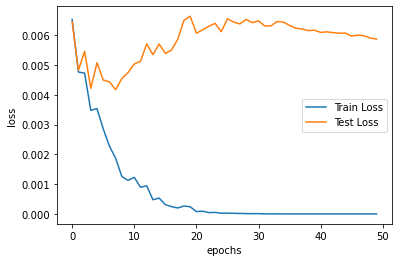

In [306]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Test Loss'])

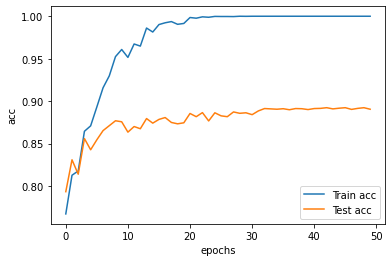

In [307]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','Test acc'])

In [308]:
max_index = test_acc.index(max(test_acc))
print('测试集最高准确率: ', max(test_acc), '\t索引:',max_index)

测试集最高准确率:  0.8922 	索引: 42


In [309]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_new = Net().to(device)
model_new.load_state_dict(torch.load(f'./model/model_{max_index}.pkl'))

<All keys matched successfully>

# 模型评估

In [310]:
train_dataset = []  #训练集重新初始化
for i in range(train_x.shape[1]):
    img = train_x[:,i].reshape(28,28,order='C')
    train_dataset.append([transform(img),np.argmax(train_y[:,i],axis=0)])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)

train_pred = []
test_pred = []
model_new.eval()   
with torch.no_grad(): 
    for _,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs = inputs.view(train_batch_size, 1, 28, 28)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_new(inputs.float())
        _, pred = torch.max(outputs.data, 1)      
        train_pred += pred.tolist()       
with torch.no_grad(): 
    for _,data in enumerate(test_loader,0):
        inputs, labels = data
        inputs = inputs.view(test_batch_size, 1, 28, 28)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_new(inputs.float())
        _, pred = torch.max(outputs.data, 1)      
        test_pred += pred.tolist()
train_pred = np.array(train_pred)
test_pred = np.array(test_pred)
train_pred,test_pred

(array([1, 1, 7, ..., 1, 2, 8]), array([2, 6, 7, ..., 6, 0, 7]))

In [311]:
print(metrics.classification_report(np.argmax(train_y,axis=0),train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      1.00      1.00       508
           2       1.00      1.00      1.00       538
           3       1.00      1.00      1.00       533
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       499
           6       1.00      1.00      1.00       463
           7       1.00      1.00      1.00       524
           8       1.00      1.00      1.00       500
           9       1.00      1.00      1.00       489

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [312]:
print(metrics.classification_report(np.argmax(test_y,axis=0),test_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       480
           1       0.98      0.98      0.98       544
           2       0.82      0.83      0.82       480
           3       0.88      0.89      0.88       480
           4       0.80      0.83      0.81       480
           5       0.96      0.96      0.96       512
           6       0.75      0.70      0.72       510
           7       0.95      0.96      0.95       496
           8       0.96      0.96      0.96       501
           9       0.96      0.96      0.96       517

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [313]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

显示百分比：
[[ 1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00]]


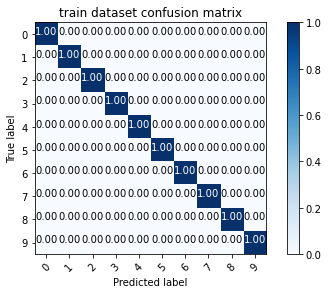

In [314]:
cm = metrics.confusion_matrix(np.argmax(train_y,axis=0),train_pred)
plot_confusion_matrix(cm,range(10),normalize=True,title='train dataset confusion matrix')

显示百分比：
[[ 0.84  0.00  0.01  0.03  0.01  0.01  0.09  0.00  0.01  0.00]
 [ 0.00  0.98  0.00  0.01  0.01  0.00  0.00  0.00  0.00  0.00]
 [ 0.01  0.00  0.83  0.01  0.07  0.00  0.07  0.00  0.00  0.00]
 [ 0.02  0.01  0.01  0.89  0.04  0.00  0.02  0.00  0.00  0.00]
 [ 0.00  0.00  0.08  0.03  0.83  0.00  0.06  0.00  0.01  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.96  0.00  0.02  0.00  0.01]
 [ 0.11  0.00  0.07  0.03  0.07  0.00  0.70  0.00  0.02  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.96  0.00  0.03]
 [ 0.01  0.00  0.00  0.00  0.01  0.01  0.00  0.00  0.96  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.03  0.00  0.96]]


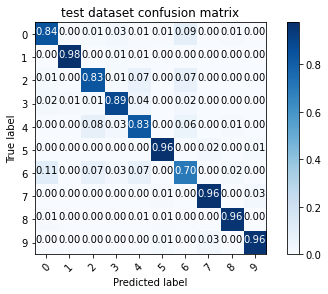

In [315]:
cm = metrics.confusion_matrix(np.argmax(test_y,axis=0),test_pred)
plot_confusion_matrix(cm,range(10),normalize=True,title='test dataset confusion matrix')

# 汇报最终结果

In [316]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_new = Net().to(device)
model_new.load_state_dict(torch.load(f'./model/model_{max_index}.pkl'))
final_x = np.load('final_x.npy')
final_pred = []
model_new.eval()        
with torch.no_grad(): 
    for i in range(final_x.shape[1]):
        img = final_x[:,i].reshape(28,28,1,order='C')
        img = transform(img)
        img = img.view(1,-1,28,28).to(device)
        output = model_new(img)
        output = output.data.cpu().numpy()[0]       
        final_pred.append(np.argmax(output))
final_pred = np.array(final_pred)
final_pred

array([9, 0, 0, ..., 7, 4, 0], dtype=int64)

In [317]:
final_pred = final_pred.reshape(1,5000)

In [318]:
with open('group_14.npy','wb') as f:
    np.save(f,final_pred)

In [319]:
data = np.load('group_14.npy')
data,data.shape

(array([[9, 0, 0, ..., 7, 4, 0]], dtype=int64), (1, 5000))